# **Predict Movie Rating Using IMDb Data**

### **Author: Ret Taylor**

<div style="text-align: center;">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/2560px-IMDB_Logo_2016.svg.png" style="width:600px;height:300px"/>

### Regression Machine Learning Project

**General Project Steps:**
1) [Project Overview](#Project-Overview)
2) [Data Collection](#Data-Collection)
3) [Data Processing](#Data-Processing)
    - [Handle Null Values](#Handle-null-values)
    - [Feature Engineering](#Feature-Engineering)
4) [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5) [Feature Scaling](#Feature-Scaling)
6) [Feature Selection](#Feature-Selection)
7) [Model Selection, Training, Tuning & Evaluation](#Model-Selection,-Training,-Tuning-&-Evaluation)
    - [Random Forest Model](#Random-Forest-Model)
    - [Decision Tree Model](#Decision-Tree-Model)
    - [Gradient Boost Regressor](#Gradient-Boost-Regression)
8) [Results](#Results)
9) [Next Steps](#Next-Steps)

### Project Overview

**Introduction:**

In this project, I develop a machine learning model to predict the IMDb rating of a movie based on several key attributes of the movie such as the director, key actors, genre, length, MPA, and oscar nominations. Accurately predicting IMDb ratings can provide valuable insights for film studios, streaming platforms, and content creators. IMDb ratings reflect audience perception and play a critical role in shaping viewership trends, marketing strategies, and production decisions.

**What are IMDb ratings & why are they important?**

IMDb (Internet Movie Database) ratings are a common measure of audience perception for movies and TV shows. IMDb ratings are based on user reviews and are scored on a scale of 1 to 10, with 10 being the highest rating. IMDb ratings are important for a couple of primary reasons - impact on viewer decision making, streaming views, and award considerations. 

**Key Data Set Features:**
- Rating: IMDb rating (scale of 1–10). **(my target feature)**
- Title: Movie title.
- Year: Year of release.
- Duration: Runtime (in minutes).
- MPA: Motion Picture Association rating (e.g., PG, R).
- Votes: Total user votes on IMDb.
- directors: List of directors.
- writers: List of writers.
- stars: Main cast members.
- genres: Movie genres.
- countries_origin: Countries of production.
- filming_locations: Primary filming locations.
- production_companies: Associated production companies.
- Languages: Languages spoken in the movie.
- nominations: Total award nominations.
- oscars: Oscar nominations.

**Project Goal:**

Create a machine learning model that accurately predicts the rating of a movie using movie features from IMDb. 

**Data Source:**

I used a dataset from Kaggle that includes data from 500-600 movies each year from 1960 to 2024 in this project. The total dataset includes over 30,000 movies.

Link to the dataset: https://www.kaggle.com/datasets/raedaddala/imdb-movies-from-1960-to-2023/data 

### Data Collection

#### Import the data set and merge all the years 

Used code from Kaggle for this step - find the code at this link:
https://www.kaggle.com/code/raedaddala/guide-to-extracting-data-from-this-dataset

In [247]:
# Import required packages
import numpy as np
import pandas as pd
import os
import re
import ast
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [10]:
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: /Users/ret/Desktop/My New JN Folder


In [11]:
root_dir = "/Users/ret/Desktop/My New JN Folder/IMDB/Data"

In [12]:
merged_data = pd.DataFrame()

In [17]:
# Create function that will search the folder that stores all the years of IMDb data and combine into one data frame
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.startswith("merged_movies_data_") and file.endswith(".csv"):
                file_path = os.path.join(folder_path, file)
                # Read the CSV file
                data = pd.read_csv(file_path)
                # Clean the Title column: remove leading numbers and trim whitespace
                data['Title'] = data['Title'].apply(lambda x: re.sub(r'^\d+\.\s*', '', str(x)).strip())
                # Step 1: Check and handle mismatched Year and release_date fields
                data['Year'] = data['Year'].astype(int)
                data['release_date'] = pd.to_numeric(data['release_date'], errors='coerce')
                data['release_date'] = data['release_date'].fillna(data['Year']).astype(int)
                mismatched_rows = data[data['Year'] != data['release_date']]
                if mismatched_rows.empty:
                    data = data.drop(columns=['release_date'])

                # Step 2: Clean the Movie Link column
                data['Movie Link'] = data['Movie Link'].apply(lambda x: re.sub(r'/\?ref_=.*$', '', str(x)))
                # Step 3: Extract and add the ID field from Movie Link
                data['id'] = data['Movie Link'].apply(lambda x: x.split('/')[-1] if '/' in x else None)
                # Step 4: Check for duplicate IDs and keep only one row per ID
                duplicate_ids = data[data.duplicated(subset=['id'], keep=False)]
                if not duplicate_ids.empty:
                    print("Duplicate IDs found:")
                    print(duplicate_ids)
                data = data.drop_duplicates(subset=['id'], keep='first')

                # Step 5: Replace empty arrays with null
                fields_to_check = ['directors', 'writers', 'stars', 'genres', 'countries_origin', 'filming_locations', 'production_companies', 'Languages']
                for field in fields_to_check:
                    if field in data.columns:
                        data[field] = data[field].apply(lambda x: None if pd.isna(x) or x.strip() == '[]' else x)

                merged_data = pd.concat([merged_data, data], ignore_index=True)

In [18]:
columns_order = ['id', 'Title'] + [col for col in merged_data.columns if col not in ['id', 'Title']]
merged_data = merged_data[columns_order]

In [21]:
print(f"Merged data shape: {merged_data.shape}")
display(merged_data.head())

Merged data shape: (33600, 23)


,id,Title,Movie Link,Year,Duration,MPA,Rating,Votes,budget,grossWorldWide,...,writers,stars,genres,countries_origin,filming_locations,production_companies,Languages,wins,nominations,oscars
0,tt1951264,The Hunger Games: Catching Fire,https://www.imdb.com/title/tt1951264,2013,2h 26m,PG-13,7.5,738K,130000000.0,8.650117e+08,...,"['Simon Beaufoy', 'Michael Arndt', 'Suzanne Co...","['Jennifer Lawrence', 'Josh Hutcherson', 'Liam...","['Dystopian Sci-Fi', 'Action', 'Adventure', 'S...",['United States'],"['Swan House - 3101 Andrews Drive Northwest, A...","['Color Force', 'Lionsgate']",['English'],0,68,0
1,tt1300854,Iron Man 3,https://www.imdb.com/title/tt1300854,2013,2h 10m,PG-13,7.1,920K,200000000.0,1.266153e+09,...,"['Drew Pearce', 'Shane Black', 'Stan Lee']","['Robert Downey Jr.', 'Guy Pearce', 'Gwyneth P...","['Superhero', 'Urban Adventure', 'Action', 'Ad...",['United States'],"['Kenansville, North Carolina, USA']","['Marvel Studios', 'Paramount Pictures', 'DMG ...",['English'],0,63,1
2,tt2294629,Frozen,https://www.imdb.com/title/tt2294629,2013,1h 42m,PG,7.4,680K,150000000.0,1.306450e+09,...,"['Jennifer Lee', 'Hans Christian Andersen', 'C...","['Kristen Bell', 'Idina Menzel', 'Jonathan Gro...","['Computer Animation', 'Fairy Tale', 'Mountain...",['United States'],"['Norway, Norge']","['Walt Disney Animation Studios', 'Walt Disney...",['English'],0,60,0
3,tt1690953,Despicable Me 2,https://www.imdb.com/title/tt1690953,2013,1h 38m,PG,7.3,438K,76000000.0,9.707660e+08,...,"['Cinco Paul', 'Ken Daurio']","['Steve Carell', 'Kristen Wiig', 'Benjamin Bra...","['Computer Animation', 'Urban Adventure', 'Adv...",['United States'],None,"['Universal Pictures', 'Illumination Entertain...","['English', 'Ukrainian']",0,66,2
4,tt0770828,Man of Steel,https://www.imdb.com/title/tt0770828,2013,2h 23m,PG-13,7.1,826K,225000000.0,6.701455e+08,...,"['David S. Goyer', 'Christopher Nolan', 'Jerry...","['Henry Cavill', 'Amy Adams', 'Michael Shannon']","['Alien Invasion', 'Superhero', 'Urban Adventu...","['United States', 'United Kingdom']","['Ucluelet, British Columbia, Canada']","['Warner Bros.', 'Legendary Entertainment', 'S...",['English'],0,46,1


In [23]:
# Save the combined data as a csv
merged_data.to_csv('final_dataset.csv', index=False)

### Data Processing

#### Handle null values

In this step, I will first check the dataframe to identify the columns that contain null values and how many null values. Then for columns that contain a relatively low number of null values, I will just drop the rows that contain null values. Then, for columns that contain a very high number of null values, I will drop the entire column. Finally for other columns that have a large number of nulls but it would make more sense to keep the column, I will fill in the nulls with "blank". 

In [28]:
# Load in the dataset
df = pd.read_csv('final_dataset.csv')

In [32]:
# Check the number of nulls in each column of the dataset
df.isnull().sum()

id                           0
Title                        0
Movie Link                   0
Year                         0
Duration                   221
MPA                       7976
Rating                     138
Votes                      138
budget                   21785
grossWorldWide           15378
gross_US_Canada          16029
opening_weekend_Gross    18077
directors                  359
writers                   1576
stars                      473
genres                     382
countries_origin           366
filming_locations         6729
production_companies      1378
Languages                  474
wins                         0
nominations                  0
oscars                       0
dtype: int64

In [34]:
# Drop rows where the rating is null in selected columns - I am just doing this for the columns with a relatively low number of nulls
df_clean = df.dropna(subset=['Rating', 'Duration', 'directors', 'stars', 'genres', 'countries_origin', 'Languages', 'writers', 'production_companies'])

In [36]:
df_clean.isnull().sum()

id                           0
Title                        0
Movie Link                   0
Year                         0
Duration                     0
MPA                       6779
Rating                       0
Votes                        0
budget                   19286
grossWorldWide           13910
gross_US_Canada          14548
opening_weekend_Gross    16414
directors                    0
writers                      0
stars                        0
genres                       0
countries_origin             0
filming_locations         5177
production_companies         0
Languages                    0
wins                         0
nominations                  0
oscars                       0
dtype: int64

In [38]:
# Drop columns where there are an excessive number of null values
df_clean_2 = df_clean.drop(columns=['budget', 'grossWorldWide', 'gross_US_Canada', 'opening_weekend_Gross'])

In [40]:
# Drop columns that are not necessary to the analysis
df_clean_3 = df_clean_2.drop(columns=['Movie Link'])

In [42]:
df_clean_3.isnull().sum()

id                         0
Title                      0
Year                       0
Duration                   0
MPA                     6779
Rating                     0
Votes                      0
directors                  0
writers                    0
stars                      0
genres                     0
countries_origin           0
filming_locations       5177
production_companies       0
Languages                  0
wins                       0
nominations                0
oscars                     0
dtype: int64

In [44]:
# For MPA & filming_locations with null values - fill in "Unknown"
df_clean_3['MPA'] = df_clean_3['MPA'].fillna('Unknown')
df_clean_3['filming_locations'] = df_clean_3['filming_locations'].fillna('Unknown')

In [46]:
df_clean_3.isnull().sum()

id                      0
Title                   0
Year                    0
Duration                0
MPA                     0
Rating                  0
Votes                   0
directors               0
writers                 0
stars                   0
genres                  0
countries_origin        0
filming_locations       0
production_companies    0
Languages               0
wins                    0
nominations             0
oscars                  0
dtype: int64

In [48]:
df = df_clean_3

#### Feature Engineering

Feature engineering is where I spent the bulk of the time on this project. I took several different approaches to transforming data in different columns based on the content in the column, the number of unique values in the column, and the type of data in the column. Some examples of transformation that I made in this section are converting strings to numbers, one hot encoding features, binary encoding features, extracting items from lists, and frequency encoding. 

##### Convert duration from string to minutes integer

With the way that the data loaded in this column, to make it useable for machine learning I had to convert the values from a string that looks like "2h 10m" to 130. To achieve this transformation, I created a function and applied it to the df.  

In [54]:
def convert_to_minutes(duration):
    """Convert a duration string (e.g., '2h 10m') to total minutes."""
    if pd.isna(duration):  # Handle NaN values
        return None
    
    hours = minutes = 0
    
    # Extract hours and minutes using regex
    match = re.match(r'(?:(\d+)h)?\s*(?:(\d+)m)?', duration)
    if match:
        if match.group(1):  # Extract hours
            hours = int(match.group(1))
        if match.group(2):  # Extract minutes
            minutes = int(match.group(2))
    
    return hours * 60 + minutes

In [56]:
df['Duration_Minutes'] = df['Duration'].apply(convert_to_minutes)

In [58]:
# Drop original duration column
df = df.drop(columns=['Duration'])

##### Convert votes from string to number

Similar to the duration column, the votes column also needed to be converted from a string to a number. In this case, the values loaded in looking like "340k" and needed to be formatted as the number 340000 to be usable for machine learning. Again, I created a function that would make this transformation and applied it to the df. 

In [62]:
def convert_k_m_notation(value):
    """Convert numbers in 'K' (thousands) or 'M' (millions) notation to actual numbers."""
    if pd.isna(value):  # Handle NaN values
        return None
    
    value = str(value).strip().upper()  # Ensure uniform format (uppercase 'K'/'M')
    
    if value.endswith('K'):
        return float(value[:-1]) * 1_000  # Convert 'K' to 1,000
    elif value.endswith('M'):
        return float(value[:-1]) * 1_000_000  # Convert 'M' to 1,000,000
    
    return float(value)  # If no suffix, return as is

In [64]:
# Applying conversion
df['Votes_Count'] = df['Votes'].apply(convert_k_m_notation)

In [66]:
# Drop original votes column
df = df.drop(columns=['Votes'])

In [68]:
# Drop id column - not beneficial to analysis
df = df.drop(columns=['id'])

##### One hot encode the MPA column

For the MPA column, I utilized one hot encoding to prepare the data for machine learing. Although, I did not want to one hot encode all the values in this column as there were many that appeared just a couple of times throughout the dataset. Therefore, I just one hot encoded the 5 values that appeared the most in the dataset. Then the others were put in the bucket "Other" which ended up having 3530 rows. 

This could be a point of improvement for the model going forward but as I wanted to keep the model relatively simple, I found this to be the best approach.

In [72]:
# One hot encode the MPA column - keeping a column for only the top 5 values
top_5_values = df['MPA'].value_counts().nlargest(5).index

# Replace less common values with "Other"
df['MPA'] = df['MPA'].apply(lambda x: x if x in top_5_values else 'Other')

# One-hot encode
df_encoded = pd.get_dummies(df, columns=['MPA'])

In [74]:
df['MPA'].value_counts()

MPA
R            9691
Unknown      6779
Not Rated    3988
PG-13        3576
Other        3520
PG           3313
Name: count, dtype: int64

##### Convert the directors column

To handle the directors column that loaded in with a comma seperated list of the directors, I extracted only the first director listed and stored that as "primary_director" which I later used frequency encoding to convert the data to a format useable for machine learning. 

In [78]:
# Extract only the first director mentioned in the column and drop the other values
df_encoded['primary_director'] = df_encoded['directors'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') else x)

In [79]:
df_encoded = df_encoded.drop(columns=['directors'])

##### Convert the stars column

For the stars column, there were several actors listed on some movies so I extracted the first 3 actors listed for each movie and stored each value in a seperate column: "lead_actor", "supporting_actor", and "third_actor". I later used frequency encoding to transform the columns into a format useable for machine learning.

In [84]:
# Create a column for each of the 3 leading actors 

# Function to extract actors from list-like strings
def extract_actors(actor_list, index):
    try:
        actor_list = ast.literal_eval(actor_list)  # Convert string to list
        if isinstance(actor_list, list) and len(actor_list) > index:
            return actor_list[index]  # Extract actor at given index
        return None  # Return None if the index doesn't exist
    except:
        return None  

In [85]:
df_encoded['lead_actor'] = df_encoded['stars'].apply(lambda x: extract_actors(x, 0))
df_encoded['supporting_actor'] = df_encoded['stars'].apply(lambda x: extract_actors(x, 1))
df_encoded['third_actor'] = df_encoded['stars'].apply(lambda x: extract_actors(x, 2))

In [88]:
# Drop the original 'stars' column
df_encoded = df_encoded.drop(columns=['stars'])

In [90]:
# There are a couple of rows that did not have 3 actors listed - I will just drop these rows since there weren't occurances
df_encoded.isnull().sum()

Title                     0
Year                      0
Rating                    0
writers                   0
genres                    0
countries_origin          0
filming_locations         0
production_companies      0
Languages                 0
wins                      0
nominations               0
oscars                    0
Duration_Minutes          0
Votes_Count               0
MPA_Not Rated             0
MPA_Other                 0
MPA_PG                    0
MPA_PG-13                 0
MPA_R                     0
MPA_Unknown               0
primary_director          0
lead_actor                0
supporting_actor         83
third_actor             163
dtype: int64

In [92]:
df = df_encoded.dropna()

##### Convert the genres column

In this column I extracted the first 2 genres listed for the movie and stored those as "primary_genre" and "secondary_genre". Then, I again used freqeuncy encoding later to convert these columns to a format useable for machine learning. 

In [96]:
# Extract the primary & secondary genres 
def extract_genre(genre_list, index):
    try:
        genre_list = ast.literal_eval(genre_list)  # Convert string to list
        if isinstance(genre_list, list) and len(genre_list) > index:
            return genre_list[index]  # Extract genre at given index
        return None  
    except:
        return None  

In [98]:
# Apply function to create new columns
df.loc[:, 'primary_genre'] = df['genres'].apply(lambda x: extract_genre(x, 0))
df.loc[:, 'secondary_genre'] = df['genres'].apply(lambda x: extract_genre(x, 1))

In [100]:
df = df.drop(columns=['genres'])

##### Drop the filming locations column

There was too much variation in this column and no simple way to convert the data in this column to a machine learning ready format so I dropped the locations column from the dataset.

In [104]:
df = df.drop(columns=['filming_locations'])

##### Binary encode the country of origin column

Since a large portion of the data had "United States" as the value in the country column, I found the best way to handle this column was to simply binary encode the data. If the country of origin is US - 1, else 0. 

This column also could have been one hot encoded and I could have pulled in more counties/columns but again for simplicity of the model, I felt that this was the best approach. 

In [108]:
# If the country of origin is the US - assign a value of 1, else assign a 0
df['US_counrty_origin'] = df['countries_origin'].apply(lambda x: 1 if 'United States' in str(x) else 0)

In [110]:
# Drop the original country of origin column
df = df.drop(columns=['countries_origin'])

##### Binary encode the languages column

Similar to the country column, I binary encoded the languages column as either english as primary language (1) or english not the primary language (0). 

In [114]:
# If the language is english - assign a value of 1, else assign a 0
df['lang_english'] = df['Languages'].apply(lambda x: 1 if 'English' in str(x) else 0)

In [115]:
# Drop the original language column
df = df.drop(columns=['Languages'])

##### Extract only the primary production company

In this column, similar to others in the dataset, I extracted the first string from the list and stored it as "primary_production_company" then later used frequency encoding to prep the column for machine learning.  

In [120]:
df['primary_production_company'] = df['production_companies'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') else x)

In [121]:
# Drop the original production companies column
df = df.drop(columns=['production_companies'])

##### Extract only the lead writer

Like the primary production column, I extracted the first item from the writers list then used frequency encoding to prep the column for machine learning.

In [126]:
df['lead_writer'] = df['writers'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') else x)

In [127]:
# Drop the original production companies column
df = df.drop(columns=['writers'])

##### Make a final check for null values

In [131]:
df.isnull().sum()

Title                            0
Year                             0
Rating                           0
wins                             0
nominations                      0
oscars                           0
Duration_Minutes                 0
Votes_Count                      0
MPA_Not Rated                    0
MPA_Other                        0
MPA_PG                           0
MPA_PG-13                        0
MPA_R                            0
MPA_Unknown                      0
primary_director                 0
lead_actor                       0
supporting_actor                 0
third_actor                      0
primary_genre                    0
secondary_genre               5421
US_counrty_origin                0
lang_english                     0
primary_production_company       0
lead_writer                      0
dtype: int64

In [133]:
# Since there are over 5000 nulls - I am going to drop the secondary genre column
df = df.drop(columns=['secondary_genre'])

In [135]:
df.isnull().sum()

Title                         0
Year                          0
Rating                        0
wins                          0
nominations                   0
oscars                        0
Duration_Minutes              0
Votes_Count                   0
MPA_Not Rated                 0
MPA_Other                     0
MPA_PG                        0
MPA_PG-13                     0
MPA_R                         0
MPA_Unknown                   0
primary_director              0
lead_actor                    0
supporting_actor              0
third_actor                   0
primary_genre                 0
US_counrty_origin             0
lang_english                  0
primary_production_company    0
lead_writer                   0
dtype: int64

##### Convert any true/false columns to 1/0

In [138]:
# List of columns to convert
cols_to_convert = ['MPA_Not Rated', 'MPA_Other', 'MPA_PG', 'MPA_PG-13', 'MPA_R', 'MPA_Unknown']

# Convert True/False to 1/0
df[cols_to_convert] = df[cols_to_convert].astype(int)

##### Apply frequency encoding for all categorical variables

In [141]:
# simple frequency encoding for the columns listed below
for col in ['primary_director', 'primary_genre', 'primary_production_company', 'lead_writer']:
    df[col + '_freq'] = df[col].map(df[col].value_counts(normalize=False))

In [143]:
# For the actors column, I counted each actors frequency across all 3 columns rather than counting the frequency of the actor in each column
# Flatten all actor occurrences into a single Series
all_actors = pd.concat([df['lead_actor'], df['supporting_actor'], df['third_actor']])

# Count occurrences of each actor across all three columns
actor_counts = all_actors.value_counts().to_dict() 

# Create new frequency columns by mapping from actor_counts
df['lead_actor_freq'] = df['lead_actor'].map(actor_counts).fillna(0).astype(int)
df['supporting_actor_freq'] = df['supporting_actor'].map(actor_counts).fillna(0).astype(int)
df['third_actor_freq'] = df['third_actor'].map(actor_counts).fillna(0).astype(int)

In [145]:
df = df.drop(columns=['primary_director', 'primary_genre', 'primary_production_company', 'lead_writer', 'lead_actor', 'supporting_actor', 'third_actor'])

### Exploratory Data Analysis

In [148]:
df.head()

,Title,Year,Rating,wins,nominations,oscars,Duration_Minutes,Votes_Count,MPA_Not Rated,MPA_Other,...,MPA_Unknown,US_counrty_origin,lang_english,primary_director_freq,primary_genre_freq,primary_production_company_freq,lead_writer_freq,lead_actor_freq,supporting_actor_freq,third_actor_freq
0,The Hunger Games: Catching Fire,2013,7.5,0,68,0,146,738000.0,0,0,...,0,1,1,8,75,1,6,18,13,13
1,Iron Man 3,2013,7.1,0,63,1,130,920000.0,0,0,...,0,1,1,4,144,26,2,46,31,27
2,Frozen,2013,7.4,0,60,0,102,680000.0,0,0,...,0,1,1,4,144,12,4,16,3,3
3,Despicable Me 2,2013,7.3,0,66,2,98,438000.0,0,0,...,0,1,1,2,144,534,7,28,20,13
4,Man of Steel,2013,7.1,0,46,1,143,826000.0,0,0,...,0,1,1,12,120,494,7,12,25,23


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30704 entries, 0 to 33599
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Title                            30704 non-null  object 
 1   Year                             30704 non-null  int64  
 2   Rating                           30704 non-null  float64
 3   wins                             30704 non-null  int64  
 4   nominations                      30704 non-null  int64  
 5   oscars                           30704 non-null  int64  
 6   Duration_Minutes                 30704 non-null  int64  
 7   Votes_Count                      30704 non-null  float64
 8   MPA_Not Rated                    30704 non-null  int64  
 9   MPA_Other                        30704 non-null  int64  
 10  MPA_PG                           30704 non-null  int64  
 11  MPA_PG-13                        30704 non-null  int64  
 12  MPA_R                  

In [152]:
df.describe()

,Year,Rating,wins,nominations,oscars,Duration_Minutes,Votes_Count,MPA_Not Rated,MPA_Other,MPA_PG,...,MPA_Unknown,US_counrty_origin,lang_english,primary_director_freq,primary_genre_freq,primary_production_company_freq,lead_writer_freq,lead_actor_freq,supporting_actor_freq,third_actor_freq
count,30704.000000,30704.000000,30704.0,30704.000000,30704.000000,30704.000000,3.070400e+04,30704.000000,30704.000000,30704.000000,...,30704.000000,30704.000000,30704.000000,30704.000000,30704.000000,30704.000000,30704.000000,30704.000000,30704.000000,30704.000000
mean,1991.900241,6.127309,0.0,5.180954,0.109465,103.414930,3.125502e+04,0.128615,0.113405,0.107608,...,0.218864,0.545010,0.708279,7.166428,2633.930888,53.902879,4.076993,14.442320,10.015698,7.297323
std,18.854978,1.122349,0.0,18.435611,0.528665,37.235771,1.104188e+05,0.334779,0.317093,0.309890,...,0.413483,0.497978,0.454562,8.543772,2511.421303,129.660402,5.690082,15.989676,12.512705,10.274756
min,1960.000000,1.100000,0.0,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1976.000000,5.400000,0.0,0.000000,0.000000,90.000000,6.090000e+02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,204.000000,1.000000,1.000000,2.000000,1.000000,1.000000
50%,1992.000000,6.300000,0.0,0.000000,0.000000,99.000000,2.500000e+03,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,4.000000,1455.000000,4.000000,2.000000,8.000000,4.000000,3.000000
75%,2008.000000,6.900000,0.0,3.000000,0.000000,111.000000,1.400000e+04,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,10.000000,5174.000000,22.000000,5.000000,23.000000,14.000000,9.000000
max,2024.000000,9.300000,0.0,433.000000,11.000000,5220.000000,3.000000e+06,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,87.000000,6222.000000,534.000000,61.000000,93.000000,93.000000,93.000000


In [154]:
# I realized that there was no data in the "wins" column so I dropped this column as it added nothing to the dataset
df = df.drop(columns=['wins'])

Creating histograms of all columns can be benficial for several reasons such as understanding the distribution of data in each of the columns, detecting imbalances in the data, analyzing the variance of different features, and for guiding scaling decisions. 

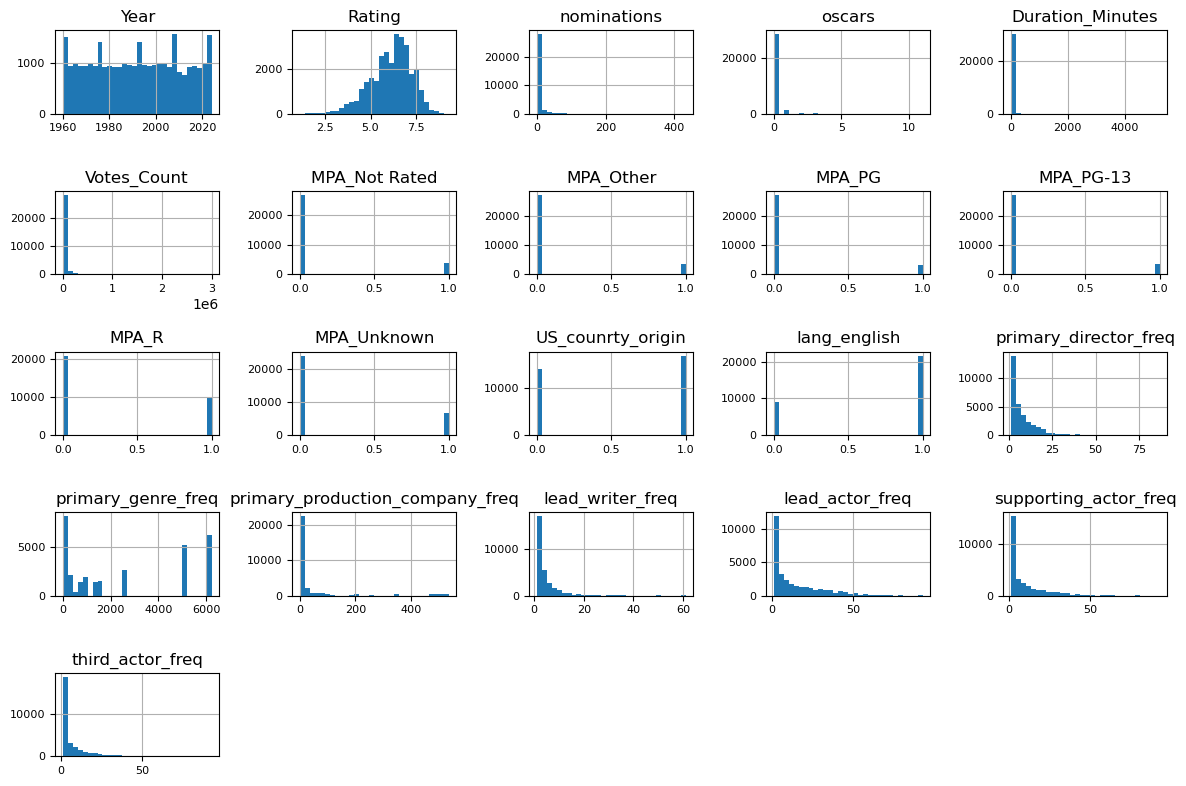

In [157]:
ax = df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()  # Adjusts layout to prevent overlap

# Reduce font size for all subplots
for sub_ax in ax.flatten():
    sub_ax.set_xlabel(sub_ax.get_xlabel(), fontsize=10)  # X-axis label size
    sub_ax.set_ylabel(sub_ax.get_ylabel(), fontsize=10)  # Y-axis label size
    sub_ax.tick_params(axis='both', labelsize=8)  # Tick label size

The next analysis I ran was in the correlation between the target variable and the other variables in the dataset. This is very beneficial in understaning which columnd have the most affect on the rating of the movie. For example, this analysis indicated that the nominations feature has the highest correlation to the rating of the movie. 

In [159]:
df_excluded = df.drop(columns=['Title'])

# Calculate the correlation matrix
corr_matrix = df_excluded.corr()

# Print the sorted correlation values for the 'Rating' column
print(corr_matrix['Rating'].sort_values(ascending=False))

Rating                             1.000000
nominations                        0.256854
Votes_Count                        0.245774
Duration_Minutes                   0.187204
oscars                             0.183330
lead_actor_freq                    0.111412
supporting_actor_freq              0.095673
MPA_Not Rated                      0.076511
Year                               0.076079
third_actor_freq                   0.069228
primary_production_company_freq    0.065248
MPA_Unknown                        0.042333
primary_director_freq              0.034358
lead_writer_freq                   0.030127
MPA_PG-13                          0.021625
MPA_Other                          0.004879
MPA_PG                            -0.012767
primary_genre_freq                -0.019030
MPA_R                             -0.102525
lang_english                      -0.134065
US_counrty_origin                 -0.151689
Name: Rating, dtype: float64


Another popular and useful way to visualize correlation between features is with a feature correlation heatmap. This chart shows the correlation of any feature to the target variable as well as to all the other columns in the dataset. The closer the number is to 1, the greater the correlation between the 2 variables. And inversely, the cells with values close to -1 indicate a strong negative correlation between the variables.

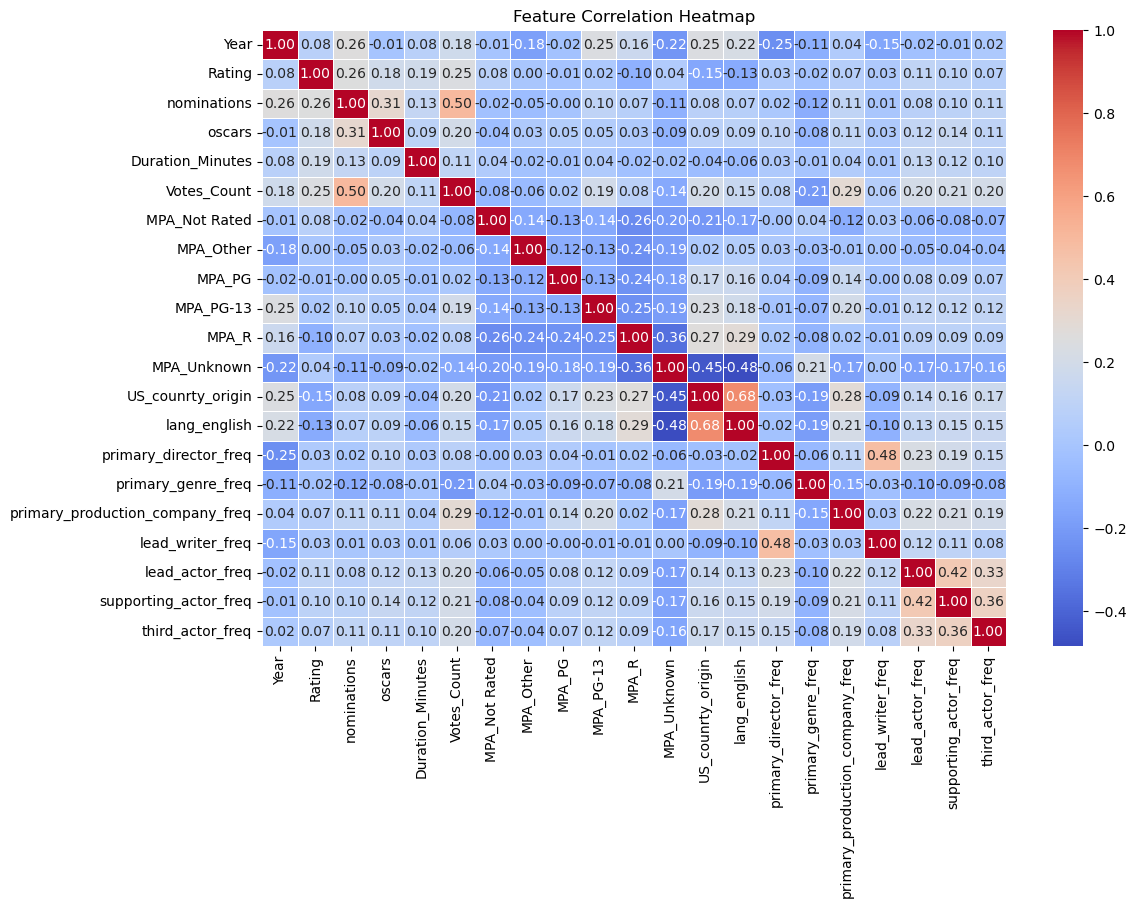

In [161]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_excluded.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Another good way to visualize relationships between variables is by using pairplots. For each column listed, there will scatter plot created showing the correlation between that column and all the other columns listed. Two plots that I think are interesting are the plots of the relationship between the votes & rating and nomination & rating. Lining up with what we found in the correlation ratings above, it seems these 2 variables (votes and nominations) have a strong positive correlation with rating. 

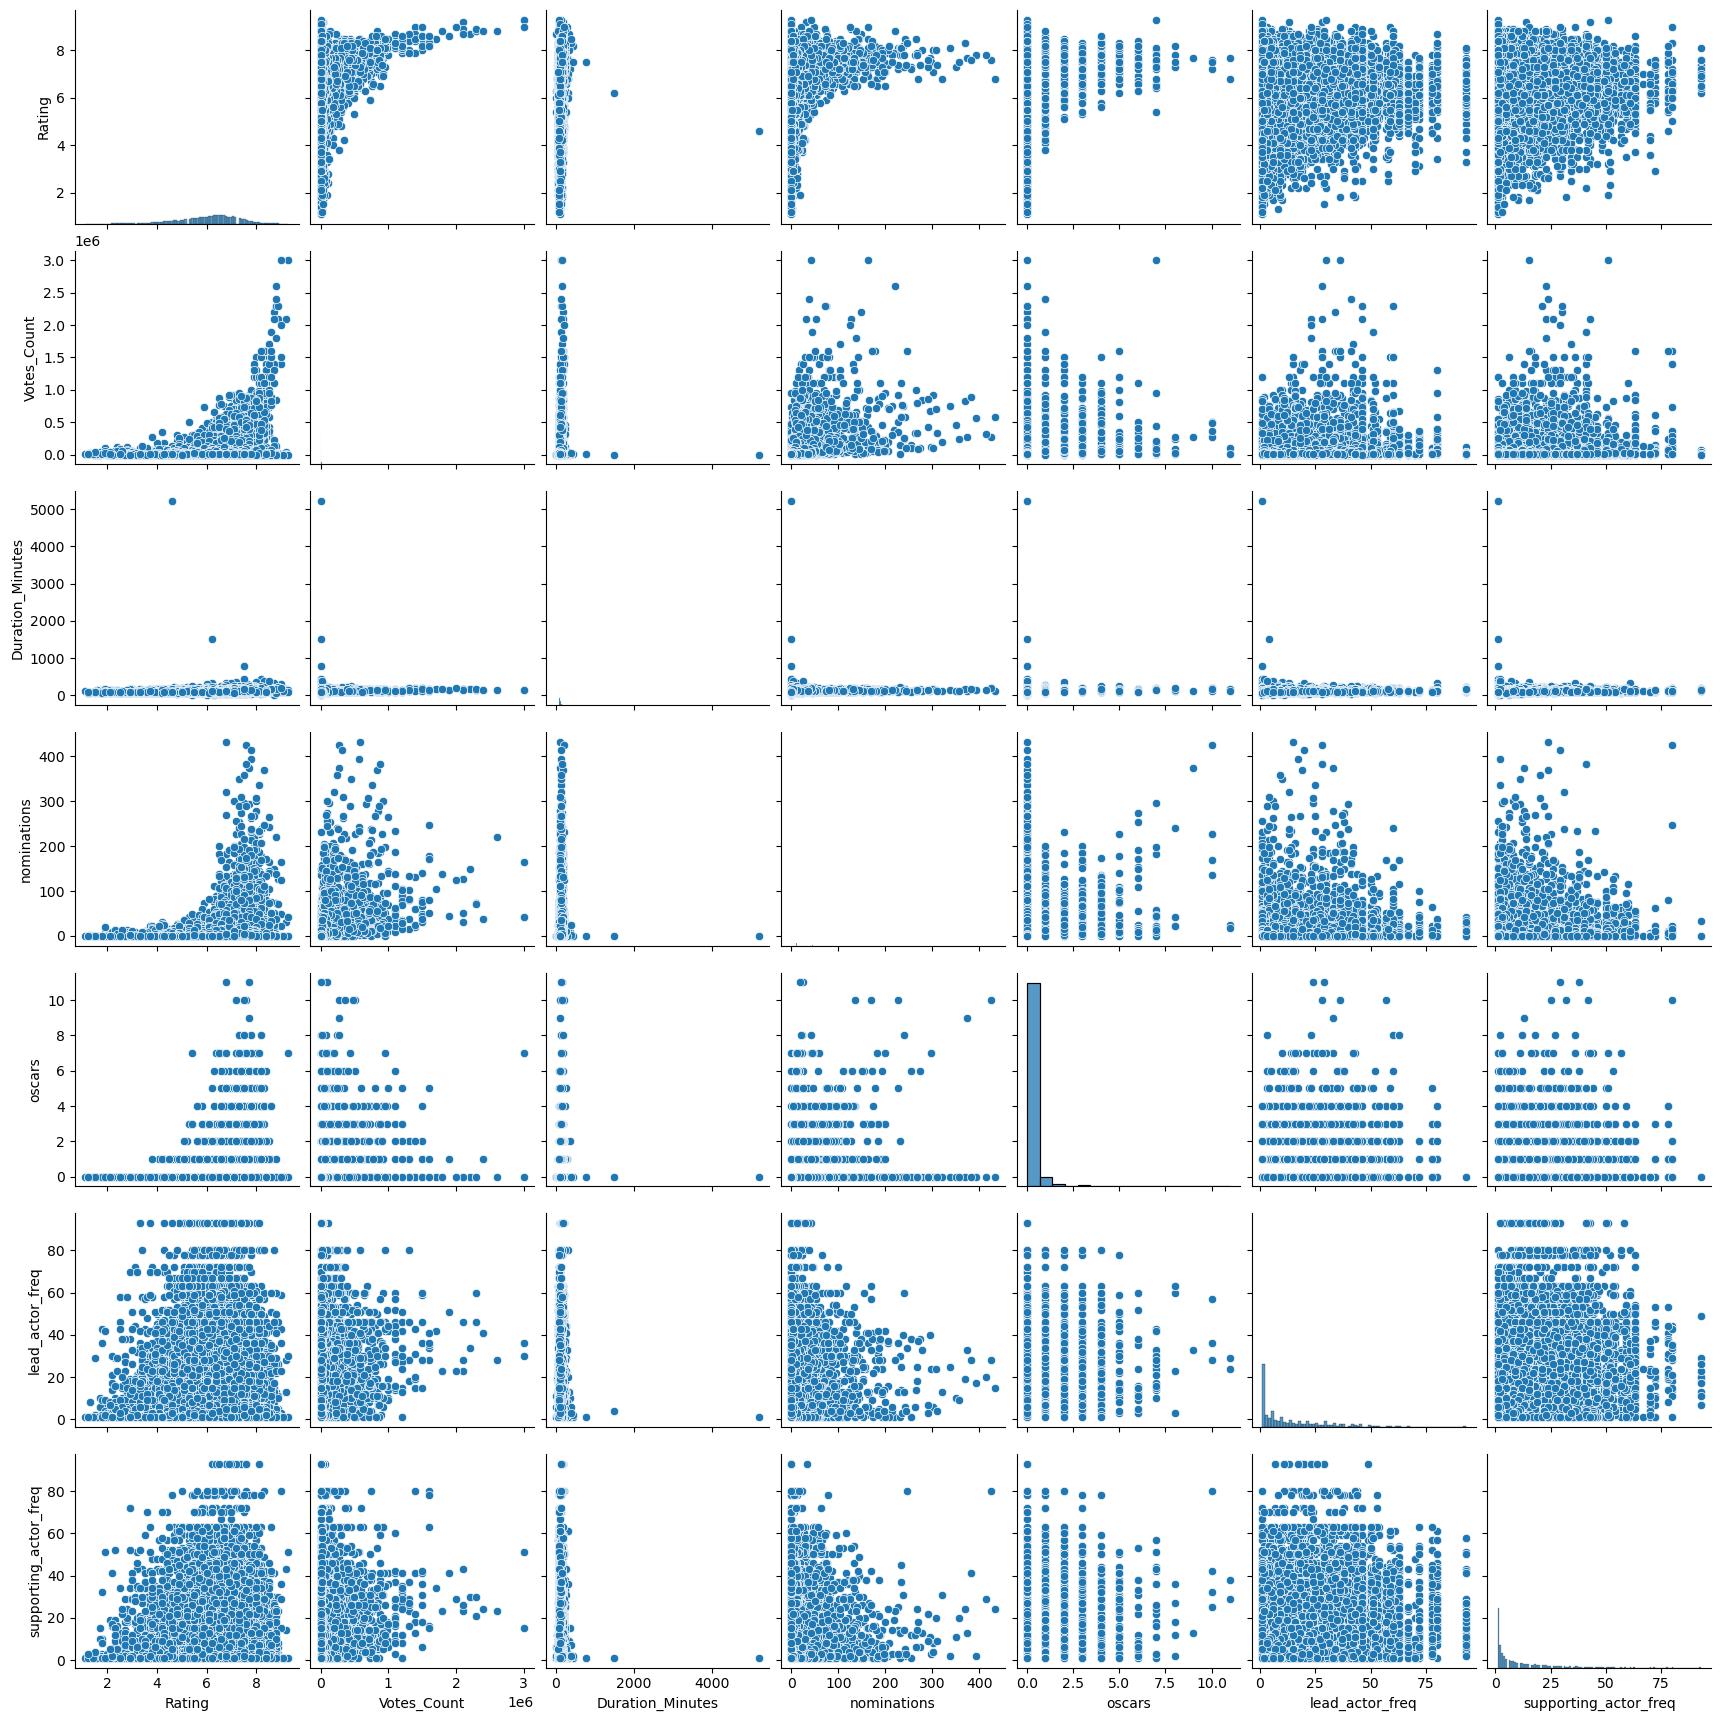

In [165]:
sns.pairplot(df[['Rating', 'Votes_Count', 'Duration_Minutes', 'nominations', 'oscars', 'lead_actor_freq', 'supporting_actor_freq']])
plt.show()

### Feature Scaling

Min max scaler puts all the values in the dataset between 0 and 1. Applying the same scale to all columns can increase the model performance as it limits the affects of biased weightings which can occur with unscaled data. 

In [169]:
scaler = MinMaxScaler()
cols_to_scale = ['nominations', 'oscars', 'Duration_Minutes', 
                 'Votes_Count', 'primary_director_freq', 'primary_genre_freq', 
                 'primary_production_company_freq', 'lead_writer_freq', 
                 'lead_actor_freq', 'supporting_actor_freq', 'third_actor_freq']

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

### Feature Selection

In [281]:
# Split the dataset into y (target) and X (all other columns)
X = df.drop(columns=['Rating', 'Title'])
y = df['Rating']

model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=15)
X_selected = rfe.fit_transform(X, y)

print("Selected Features:", X.columns[rfe.support_])

Selected Features: Index(['Year', 'nominations', 'Duration_Minutes', 'Votes_Count', 'MPA_R',
       'MPA_Unknown', 'US_counrty_origin', 'lang_english',
       'primary_director_freq', 'primary_genre_freq',
       'primary_production_company_freq', 'lead_writer_freq',
       'lead_actor_freq', 'supporting_actor_freq', 'third_actor_freq'],
      dtype='object')


In [283]:
X_selected_df = X.loc[:, X.columns[rfe.support_]]

In [285]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=42)

### Model Selection, Training, Tuning & Evaluation

#### Random Forest Model

In [326]:
# Train a model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.630684781631656


In [327]:
# Calculate the variance of the target variable
target_variance = np.var(y)
print("Target Variable Variance:", target_variance)

# Compare with MSE
print("Model MSE:", mse)

Target Variable Variance: 1.2596258233974222
Model MSE: 0.630684781631656


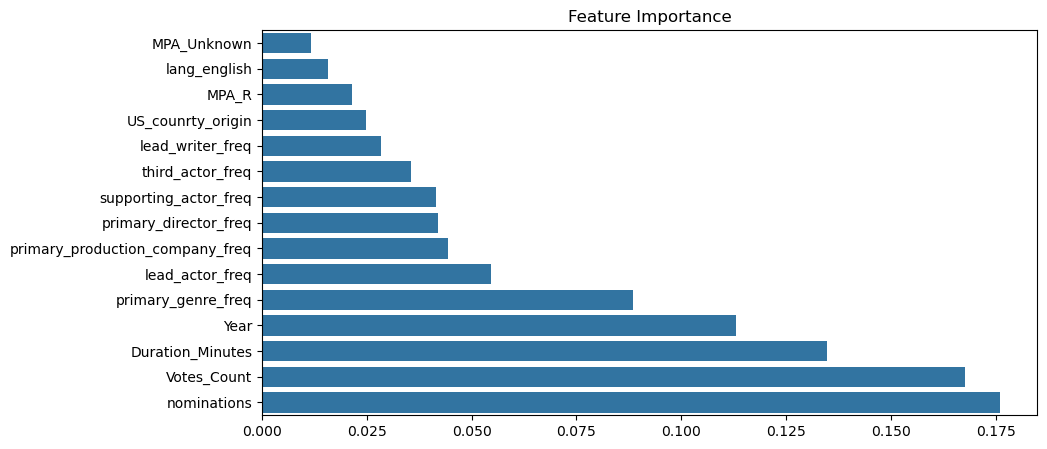

In [330]:
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances[sorted_idx], y=[features[i] for i in sorted_idx])
plt.title("Feature Importance")
plt.show()

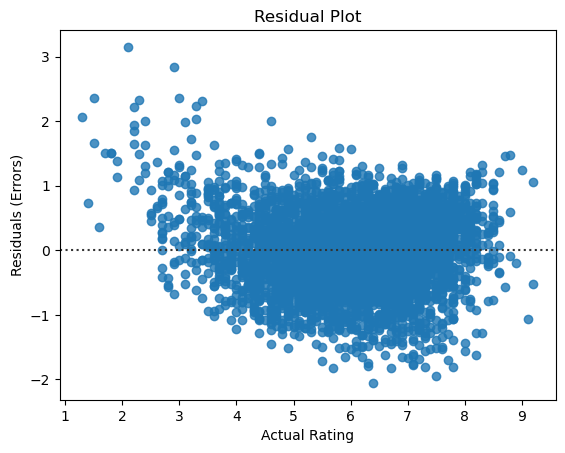

In [332]:
sns.residplot(x=y_test, y=y_pred)
plt.xlabel("Actual Rating")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot")
plt.show()

#### Decision Tree Model

In [179]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

In [180]:
# Compute MSE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree MSE:", mse)
print("Decision Tree R² Score:", r2)

Decision Tree MSE: 0.8536674126587233
Decision Tree R² Score: 0.32822766668157677


#### Gradient Boosting Regression

In [289]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [291]:
y_pred = xgb.predict(X_test)

In [293]:
# Compute MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost MSE:", mse)
print("XGBoost R² Score:", r2)

XGBoost MSE: 0.6219154585620259
XGBoost R² Score: 0.5105991015589693


In [295]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(XGBRegressor(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=20,  # Number of random combinations to try
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [296]:
refined_param_grid = {
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'learning_rate': [best_params['learning_rate'] * 0.8, best_params['learning_rate'], best_params['learning_rate'] * 1.2],
    'max_depth': [max(3, best_params['max_depth'] - 1), best_params['max_depth'], best_params['max_depth'] + 1],
    'subsample': [best_params['subsample'] - 0.1, best_params['subsample'], min(1.0, best_params['subsample'] + 0.1)],
    'colsample_bytree': [best_params['colsample_bytree'] - 0.1, best_params['colsample_bytree'], min(1.0, best_params['colsample_bytree'] + 0.1)]
}

random_search_2 = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=refined_param_grid,
    n_iter=10, 
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

random_search_2.fit(X_train, y_train)

print("Best Parameters (2nd Round):", random_search_2.best_params_)

Best Parameters (2nd Round): {'subsample': 0.8, 'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.038400000000000004, 'colsample_bytree': 0.8}


In [303]:
# Extract best parameters from the search
best_params = random_search_2.best_params_  # or grid_search.best_params_

# Initialize XGBoost with best parameters
xgb_best = XGBRegressor(**best_params, random_state=42)

# Train the model on full training data
xgb_best.fit(X_train, y_train)

# Make predictions
y_pred_best = xgb_best.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print("XGBoost MSE (Optimized):", mse)
print("XGBoost RMSE (Optimized):", rmse)
print("XGBoost R² Score (Optimized):", r2)

XGBoost MSE (Optimized): 0.573509120257381
XGBoost RMSE (Optimized): 0.7573038493612594
XGBoost R² Score (Optimized): 0.5486912652612661


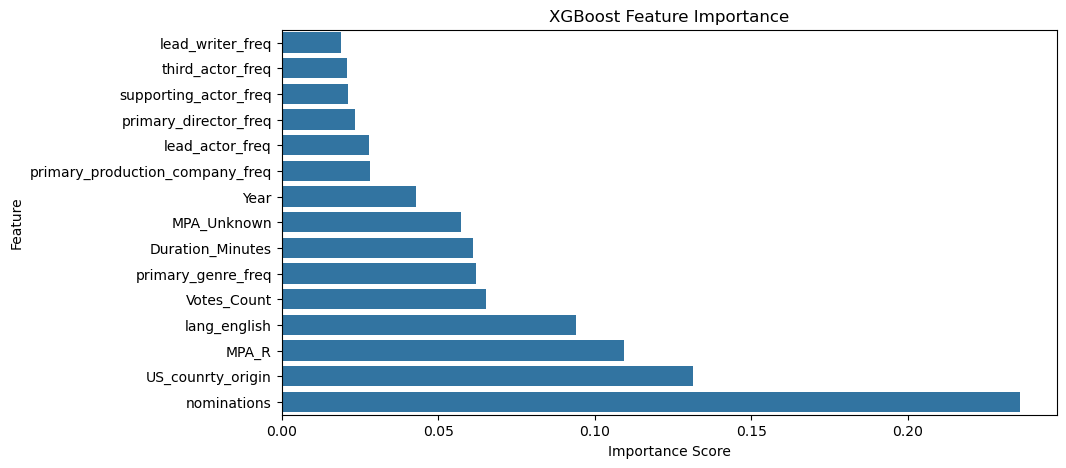

In [301]:
# Get feature importance scores
feature_importances = xgb_best.feature_importances_

# Sort features by importance
sorted_idx = feature_importances.argsort()
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances[sorted_idx], y=[features[i] for i in sorted_idx])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

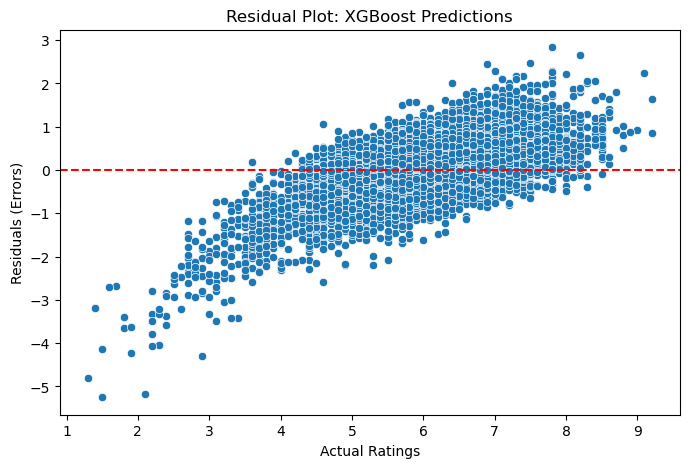

In [320]:
residuals = y_test - y_pred_best  # Actual - Predicted

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Zero error line
plt.xlabel("Actual Ratings")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot: XGBoost Predictions")
plt.show()

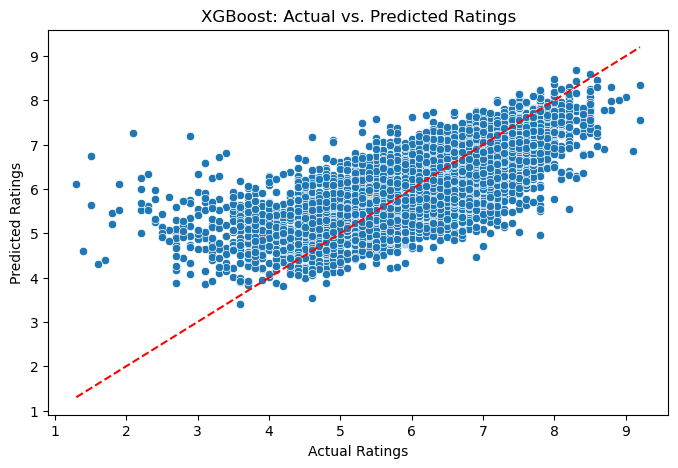

In [322]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # 45-degree line
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("XGBoost: Actual vs. Predicted Ratings")
plt.show()

### Results

In [313]:
# Make a df with my predictions, the actuals, and the delta
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference': y_test - y_pred
})

In [315]:
results_df.head()

,Actual,Predicted,Difference
27190,6.0,6.057723,-0.057723
1660,6.5,6.213621,0.286379
5261,7.0,6.199103,0.800897
29910,4.9,5.577672,-0.677672
3755,6.8,5.837466,0.962534


In [317]:
results_df.describe()

,Actual,Predicted,Difference
count,6141.000000,6141.000000,6141.000000
mean,6.112490,6.113924,-0.001434
std,1.127376,0.739227,0.788679
min,1.300000,3.953953,-5.241599
25%,5.400000,5.579246,-0.387139
50%,6.200000,6.120544,0.071057
75%,6.900000,6.635542,0.487388
max,9.200000,8.581786,2.540390


The gradient boosting regression model performed the best of the 3 model types that I tested in this project. The mean squared error (MSE) score for the XGBoost model was 0.574 which is significantly lower than the variance of the target variable (Rating) at 1.260 - indicating that the model was successful in identifying trends/correlation between the variables.

### Next Steps

What are some things that I could do to further improve the model and bring the MSE under 0.5?
- further hyperparameter tuning (continue to test & tweak the parameters of the XGBoost Model)
- further feature engineering (add more columns to the model around features that have high correlation to the target of Rating)
    - wins to nominations ratio column
    - log transformation of the votes column to reduce skew
- test with more model types

### Save the Model

In [406]:
joblib.dump(xgb_best, "movie_rating_predictor.pkl")

['movie_rating_predictor.pkl']